Τίτλος: <b>ΠΟΛΥ-ΟΜΙΚΗ ΑΝΑΛΥΣΗ ΓΕΝΟΜΙΚΩΝ ΔΕΔΟΜΕΝΩΝ ΓΙΑ ΤΗΝ ΚΑΤΗΓΟΡΙΟΠΟΙΗΣΗ ΔΕΙΓΜΑΤΩΝ ΓΛΟΙΟΒΛΑΣΤΩΜΑΤΟΣ</b><br>
Ονοματεπώνυμο φοιτητή: Οικονόμου Νικόλαος<br>
Αριθμός Μητρώου: ΤΠ4845<br>
Επιβλέπων καθηγητής: Τσικνάκης Μανώλης<br>
Συν-Επιβλέπων καθηγητής: Κουμάκης Λευτέρης

###### Notes
1.0 -> DEAD<br>
0.0 -> ALIVE
<br>
Lung,breast allo format sto id(clinical&surv)se sxesi me toys ypololipous

Προσθήκη βιβλιοθηκών

In [1]:
# Load libraries
import numpy as np
import pandas as pd

from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn import tree
from sklearn.feature_selection import SelectKBest, f_classif

In [2]:
from sklearn.preprocessing import MinMaxScaler

from sklearn import svm
import matplotlib.pyplot as plt

import seaborn as sns

from imblearn.over_sampling import SMOTE
from collections import Counter

from sklearn.metrics import confusion_matrix
from sklearn.metrics import plot_confusion_matrix

In [4]:
#pd.set_option('display.max_rows', None)
#pd.reset_option('display.max_rows')

### Function Area

In [5]:
def GenomeDataReader(GenesExp,DnaMethylation,miRNA,survivalData,clinicalData):
    exp = pd.read_csv(GenesExp, sep=" ") #geneExpression
    methy = pd.read_csv(DnaMethylation, sep=" ") #DNA Methylation
    mirna = pd.read_csv(miRNA, sep=" ") #miRNA
    survival = pd.read_csv(survivalData, sep="\t") #Survival file
    clinical = pd.read_csv(clinicalData, sep="\t") #clinical file
    
    return exp,methy,mirna,survival,clinical

#Call function
#genes,methylation,mirna,surv,clin = GenomeDataReader("C:/Users/Nikos Oikonomou/Desktop/CancerDataTCGA/aml/exp","C:/Users/Nikos Oikonomou/Desktop/CancerDataTCGA/aml/methy","C:/Users/Nikos Oikonomou/Desktop/CancerDataTCGA/aml/mirna","C:/Users/Nikos Oikonomou/Desktop/CancerDataTCGA/aml/survival","C:/Users/Nikos Oikonomou/Desktop/CancerDataTCGA/aml/aml")

In [6]:
#Me to surv anti to df paradeigma, allazei to arxiko dataframe kai oxi kapoio antigrafo tou
#An thelo na min xalaei to arxiko survival arxeio, prepei anti surv= na bazo to df=
#Svinei ola ta duplicates apo to survival arxeio

#Epistrefei to SURVIVAL dataframe refactored

def survivalData(surv):
    
    surv = surv[["PatientID","Death"]] #pairno tis stiles PatientID kai Death
    
    #διαγραφή των duplicates
    surv=surv.drop_duplicates(subset=['PatientID'])
    
    #διαγραφη όλων των NaN τιμών της στήλης
    surv = surv[~surv.isnull().any(axis=1)]
    surv=surv.reset_index(drop=True) #Κάνει το index να είναι σωστά αριθμημένο απο 0
    
    #Αντικατάσταση - με .
    surv['PatientID'] = surv['PatientID'].str.replace('-','.')
    
    #ψαχνω αν το id ειναι με μικρά και το αλλ΄αζω
    for i in range(len(surv['PatientID'])):
        if(surv.loc[i,'PatientID'].islower()): 
            surv['PatientID'] = surv['PatientID'].str.upper() #το κανει κεφαλαια
            surv['PatientID'] = surv['PatientID']+'.01' #προσθ΄ετει το .01
        else:
            pass
     
    #επιστρέφει το survival refactored
    return surv

In [7]:
#στα ομικά σετς αλλάζει τις - με . οπου υπαρχουν
def omicDatasetRefactor(genes,methylation,mirna):
    genes.columns = genes.columns.str.replace("-", ".")
    methylation.columns = methylation.columns.str.replace("-", ".")
    mirna.columns = mirna.columns.str.replace("-", ".")
    
    return genes,methylation,mirna

In [8]:
#pairnei kathe dataframe(genes,methylation,mirna,surv) to kanei lista kai virskei metaksi toys, ta koina ids
#παίρνει καθε νταταφρειμ (genes,methylation,mirna,surv) το κάνει λίστα και βρίσκει μεταξύ τους τα κοινά ids

#Επιστρέφει τη λιστα με τα κοινά ids
def findCommonPatients(genes,methylation,mirna,surv):
    
    colNamesGenes=[]
    for i in genes.columns:
        colNamesGenes.append(i)

    colNamesMethy=[]
    for i in methylation.columns:
        colNamesMethy.append(i)

    colNamesmirna=[]
    for i in mirna.columns:
        colNamesmirna.append(i)

        
    survivalIDs=[]
    for i in surv['PatientID']:
        survivalIDs.append(i)
        
    elements_in_all = list(set.intersection(*map(set, [colNamesGenes, colNamesMethy, colNamesmirna,survivalIDs])))
    elements_in_all.sort()
    
    
    return elements_in_all

In [9]:
#βρισκει τους κοινους ασθενείς σε κάθε σετ που υπάρχουν στην λίστα commonPatients
def commonPatientsRefactor(dataframe,surv,commonPatients):
    
    #εδώ βρίσκω τις θέσεις(indexes) που βρίσκονται τα κοινά ids στο αρχείο survival
    indexList=[]
    for i in range(len(surv)):
        if (surv.loc[i,'PatientID'] in commonPatients):
            indexList.append(i)

    dfT=dataframe.T #κάνω το transposed το εκάστοτε dataset

    #βρίσκω τα sampleID(index) των κοινών ασθενών στο εκάστοτε dataset - (το dataset πρέπει να είναι transposed)
    #έτσι ώστε να παραχθεί το νέο dataframe
    lista=[]
    for i in range(len(dfT)):
         if (dfT.index[i] in commonPatients):
            lista.append(i)

    #Ολοκλήρωση του νέου dataframe(προσθήκη του CDE_vital_status) 
    dataframe = dfT.iloc[lista] #ε΄δώ έχουμε το νέο dataframe χωρίς την κολώνα με το classification
    dataframe = dataframe.sort_index(ascending=True) #to sortarei
    survivalFinal = surv.iloc[indexList] 

    #εδώ φτιάχνω το survival dataframe να ειναι μονο με τους κοινους ασθενεις
    survivalFinal = survivalFinal.sort_values(by=['PatientID'])
    survivalFinal = survivalFinal.reset_index(drop=True)
    survivalFinal.index = survivalFinal['PatientID'] #ορίζω το PatientId ως index στο νέο dataframe
    survivalFinal = survivalFinal.drop(['PatientID'],axis=1)

    #προσθήκη της κολώνας Death στο τέλος του dataframe - εχω το τελικο dataframe
    dataframeFinalMorfi = pd.concat([dataframe,survivalFinal['Death']],axis=1)

    return dataframeFinalMorfi

In [10]:
#Κανει normalize τα δεδομένα
def dataNormalization(dataframe):
    X_copy = dataframe.iloc[:,:-1].copy() #Αντιγραφή του dataframe ώστε να μη "χαλάσει" το αρχικό σε περίπτωση που χρειαστεί να αναφερθούμε σε αυτο
    
    #Χρήση της συνάρτησης MinMaxScaler()
    scaler = MinMaxScaler()
    X_columns = dataframe.iloc[:,:-1].columns #επλέγουμε όλες τις κολώνες πλήν της τελευταίας που ειναι οι κλάσεις μας
    X_scaled = pd.DataFrame(scaler.fit_transform(X_copy), columns=X_columns) #γίνεται ομαλοποίηση στις τιμές
    
    #Προστίθεται ξανά η κολώνα με τις κλάσεις μας και έχουμε το τελικό ομαλοποιημένο σύνολο
    last_column = dataframe.iloc[: , -1]
    X_scaled.index = dataframe.index
    X_scaled['Death'] = last_column
    
    return X_scaled

In [11]:
#δινω τα 3 ομικά σετς και τα ενώνει σε ένα ενιαιο (δεν εχει σημασια η σειρα που δίνονται)
def concatenation(df1,df2,df3):
    dataframe = pd.concat([df1,df2,df3],axis=1) #γίνεται μια "πρώτη" συνένωση των GeneExp,DNA Methylation & miRNA
    
    selected_rows = dataframe[~dataframe.isnull().any(axis=1)] #κρατάμε τις γραμμές χωρίς NaN τιμές
    
    last_column = selected_rows.iloc[: , -1] #κραταω την τελευταια στηλη με το classification
    selected_rows.drop(selected_rows['Death'], axis=1, inplace=True) #την σβηνω
    selected_rows['Death']=last_column #την ξαναπροσθέτω
    
    return selected_rows

In [12]:
#Εφαρμογή SVM 
def svmAlgorithm(X_train, X_test, y_train, y_test):
    #X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1) #, random_state=1

    #Δημιουργία SVM Classifier
    clf = svm.SVC(kernel='linear') # Linear Kernel

    #Εκπα΄ίδευση του μοντέλου χρησιμοποιώντας τα δεδομένα εκπαίδευσης(training sets)
    clf.fit(X_train,y_train)

    #Πρόβλεψη του μοντέλου στα δεδομένα δοκιμ΄ής(test dataset)
    y_pred = clf.predict(X_test)
    
    #print("SVM Accuracy:",metrics.accuracy_score(y_test, y_pred))
    
    return y_pred,clf
    
    #return y_test,y_pred

In [13]:
#Εφαρμογή DecisionTree
def treeAlgorithm(X_train, X_test, y_train, y_test):
    
    #Δημιουργία DecisionTree Classifier
    clf = DecisionTreeClassifier()

    # Εκπαίδευση του  DecisionTree Classifer
    clf = clf.fit(X_train,y_train)

    #Πρόβλεψη του μοντέλου στα δεδομένα δοκιμ΄ής(test dataset)
    y_pred = clf.predict(X_test)


    #print("Decision Tree Accuracy:",metrics.accuracy_score(y_test, y_pred))
    
    return y_pred,clf
    #return y_test,y_pred
    #return clf

In [37]:
#Confusion Matrix εμφάνιση
from sklearn.metrics import ConfusionMatrixDisplay

def confusionMatrix(X_test,y_test,y_pred,clf):
    #labels = ['LIVING','DECEASED']
    disp = plot_confusion_matrix(clf,X_test,y_test, cmap='Blues', values_format='.3g')
    
    #disp = ConfusionMatrixDisplay.from_estimator(clf, X_test, y_test, cmap='Blues', values_format='.3g') #, display_labels=labels

In [15]:
#Εφαρμογή SMOTE σε κάθε dataset
def smoteAlgorithm(df):
    data = df.values
    X, y = data[:, :-1], data[:, -1]

    #μετατροπή του dataset
    oversample = SMOTE()
    X, y = oversample.fit_resample(X, y)
    #return X,y
    
    #Μετράμε τον νέο αριθμό των κλάσεων (πόσα DECEASED και LIVING έχουμε τώρα)
    counter = Counter(y)
    print(counter)
    """
    # scatter plot of examples by class label
    for label, _ in counter.items():
        row_ix = where(y == label)[0]
        pyplot.scatter(X[row_ix, 0], X[row_ix, 1], label=str(label))
    pyplot.legend()
    pyplot.show()
    """
    return X,y

In [16]:
#Εφαρμόζει SVM & DT στο κάθε dataset
#Εμφανίζει accuracies & conf matrix 
def applyModels(dfNormalize):
    data = dfNormalize.values
    X, y = data[:, :-1], data[:, -1]

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1) #, random_state=1

    y_pred,clf = svmAlgorithm(X_train, X_test, y_train, y_test)
    confusionMatrix(X_test,y_test,y_pred,clf)
    print("SVM Accuracy:",metrics.accuracy_score(y_test, y_pred))

    y_pred,clf = treeAlgorithm(X_train, X_test, y_train, y_test)
    print("DecisionTree Accuracy:",metrics.accuracy_score(y_test, y_pred))
    confusionMatrix(X_test,y_test,y_pred,clf)

In [17]:
#Εφαρμόζει τον αλγόριθμο για feature selection ANOVA

def featureSelection(dataframe):
    data = dataframe
    X = data.iloc[:,:-1]  #independent columns
    y = data.iloc[:,-1]    #target column i.e price range

    #εφαρμογή SelectKBest για εξαγωγή των 10 καλύτερων χαρακτηριστικών
    bestfeatures = SelectKBest(f_classif, k=10)
    fit = bestfeatures.fit(X,y)
    dfscores = pd.DataFrame(fit.scores_)
    dfcolumns = pd.DataFrame(X.columns)
 
    #συνένωση των δυο σετς για καλυτερη οπτικοποίηση
    featureScores = pd.concat([dfcolumns,dfscores],axis=1)
    featureScores.columns = ['Specs','Score']  #ονομασία των dataframe columns
    #print(featureScores.nlargest(10,'Score'))  #print 10 best features
    
    #βάζω τα τοπ 10 χαρακτηριστικά σε λίστα
    topTenFeatures = featureScores.nlargest(10,'Score')
    lista = topTenFeatures['Specs'].tolist()

    
    #ψάχνω στο αρχικό dataframe τα τοπ 10 χαρακτηριστικά και δημιουργώ νέο dataframe
    dataframe_fs = dataframe[lista]

    #προσθέτω την κλάση Death στο τελος του dataframe
    last_column = dataframe.iloc[: , -1]
    dataframe_fs['Death'] = last_column
    
    #σβήνει το warning
    pd.set_option('mode.chained_assignment', None)
    #pd.options.mode.chained_assignment = None  # default='warn'

    return dataframe_fs

# End of functions

Διαβάζω τα αρχεία απο το pc βαζοντας οτι καρκίνο θελω

In [97]:
cancers=['liver','breast','ovarian','sarcoma','kidney','lung','colon','aml','gbm','melanoma']
print (cancers)

cancerType = input("Please enter Cancer name from the list: ")
cancerType = cancerType.lower()


genesFile="C:/Users/nikos/Desktop/ΠΤΥΧΙΑΚΗ ΕΡΓΑΣΙΑ/version2_ptyxiaki/CancerDataTCGA/{}/exp".format(cancerType)
methyFile="C:/Users/nikos/Desktop/ΠΤΥΧΙΑΚΗ ΕΡΓΑΣΙΑ/version2_ptyxiaki/CancerDataTCGA/{}/methy".format(cancerType)
mirnaFile="C:/Users/nikos/Desktop/ΠΤΥΧΙΑΚΗ ΕΡΓΑΣΙΑ/version2_ptyxiaki/CancerDataTCGA/{}/mirna".format(cancerType)
survFile="C:/Users/nikos/Desktop/ΠΤΥΧΙΑΚΗ ΕΡΓΑΣΙΑ/version2_ptyxiaki/CancerDataTCGA/{}/survival".format(cancerType)
clinFile="C:/Users/nikos/Desktop/ΠΤΥΧΙΑΚΗ ΕΡΓΑΣΙΑ/version2_ptyxiaki/CancerDataTCGA/{}/{}".format(cancerType,cancerType)

genes,methylation,mirna,surv,clin = GenomeDataReader(genesFile,methyFile,mirnaFile,survFile,clinFile)

['liver', 'breast', 'ovarian', 'sarcoma', 'kidney', 'lung', 'colon', 'aml', 'gbm', 'melanoma']
Please enter Cancer name from the list: kidney


In [98]:
#sosto
#genes,methylation,mirna,surv,clin = GenomeDataReader("C:/Users/Nikos Oikonomou/Desktop/CancerDataTCGA/ovarian/exp","C:/Users/Nikos Oikonomou/Desktop/CancerDataTCGA/ovarian/methy","C:/Users/Nikos Oikonomou/Desktop/CancerDataTCGA/ovarian/mirna","C:/Users/Nikos Oikonomou/Desktop/CancerDataTCGA/ovarian/survival","C:/Users/Nikos Oikonomou/Desktop/CancerDataTCGA/ovarian/ovarian")

Το αφηνω να δω πως ειναι πριν την επεξεργασια το survival αρχειο

In [99]:
surv.sort_values('PatientID') #edo to afino na vlepo pos einai prin tis allages

,PatientID,Survival,Death
0,TCGA-3Z-A93Z-01,385.0,0.0
1,TCGA-6D-AA2E-01,362.0,0.0
2,TCGA-A3-3306-01,1120.0,0.0
3,TCGA-A3-3306-11,1120.0,0.0
4,TCGA-A3-3307-01,1436.0,0.0
...,...,...,...
940,TCGA-MM-A563-01,591.0,0.0
941,TCGA-MM-A564-01,607.0,0.0
942,TCGA-MM-A84U-01,700.0,0.0
943,TCGA-MW-A4EC-01,498.0,0.0


Καλώ τη survivalData και φτιαχνει το αρχειο στη σωστη μορφη

In [100]:
surv = survivalData(surv)
surv

,PatientID,Death
0,TCGA.3Z.A93Z.01,0.0
1,TCGA.6D.AA2E.01,0.0
2,TCGA.A3.3306.01,0.0
3,TCGA.A3.3306.11,0.0
4,TCGA.A3.3307.01,0.0
...,...,...
938,TCGA.MM.A563.01,0.0
939,TCGA.MM.A564.01,0.0
940,TCGA.MM.A84U.01,0.0
941,TCGA.MW.A4EC.01,0.0


Σε περιπτωση που ενα dataset εχει - αντι . στα columns τα διορθωνει ωστε να μην υπαρχει θεμα (μονο το methylation στο ovarian ειναι )

In [101]:
genes,methy,mirna = omicDatasetRefactor(genes,methylation,mirna)

Βρισκω τους κοινους ασθενεις ολων των αρχειων (genes,methylation,miRNA,survival)

In [102]:
#Koinoi asthenois metaksi ton arxeion
commonPatients = findCommonPatients(genes,methylation,mirna,surv)
commonPatients

['TCGA.3Z.A93Z.01',
 'TCGA.6D.AA2E.01',
 'TCGA.A3.3358.01',
 'TCGA.A3.3387.01',
 'TCGA.A3.A6NI.01',
 'TCGA.A3.A6NJ.01',
 'TCGA.A3.A6NL.01',
 'TCGA.A3.A6NN.01',
 'TCGA.A3.A8CQ.01',
 'TCGA.A3.A8OV.01',
 'TCGA.A3.A8OW.01',
 'TCGA.AK.3440.01',
 'TCGA.AK.3458.01',
 'TCGA.B0.4698.01',
 'TCGA.B0.4700.01',
 'TCGA.B0.4706.01',
 'TCGA.B0.4710.01',
 'TCGA.B0.4712.01',
 'TCGA.B0.4712.11',
 'TCGA.B0.4810.01',
 'TCGA.B0.4811.01',
 'TCGA.B0.4815.01',
 'TCGA.B0.4816.01',
 'TCGA.B0.4818.01',
 'TCGA.B0.4821.01',
 'TCGA.B0.4852.01',
 'TCGA.B0.5080.01',
 'TCGA.B0.5399.01',
 'TCGA.B0.5400.01',
 'TCGA.B0.5402.01',
 'TCGA.B0.5402.11',
 'TCGA.B0.5690.01',
 'TCGA.B0.5691.01',
 'TCGA.B0.5692.01',
 'TCGA.B0.5693.01',
 'TCGA.B0.5694.01',
 'TCGA.B0.5695.01',
 'TCGA.B0.5696.01',
 'TCGA.B0.5697.01',
 'TCGA.B0.5698.01',
 'TCGA.B0.5699.01',
 'TCGA.B0.5700.01',
 'TCGA.B0.5701.01',
 'TCGA.B0.5702.01',
 'TCGA.B0.5703.01',
 'TCGA.B0.5705.01',
 'TCGA.B0.5706.01',
 'TCGA.B0.5707.01',
 'TCGA.B0.5709.01',
 'TCGA.B0.5710.01',


In [103]:
len(commonPatients)

206

Δημιουργει τα νεα σετς με τους κοινους ασθενεις μονο και εχει προσθεσει στο τελος αν ειναι ζωντανοι ή οχι

In [104]:
test1Genes = commonPatientsRefactor(genes,surv,commonPatients)
test2Methylation = commonPatientsRefactor(methylation,surv,commonPatients)
test3mirna = commonPatientsRefactor(mirna,surv,commonPatients)

Κανει ομαλοποίηση στις τιμές των παραπανω σετς

In [105]:
#normalize data
genesN = dataNormalization(test1Genes)
methylationN = dataNormalization(test2Methylation)
mirnaN = dataNormalization(test3mirna)

Κανει συνένωση των ομαλοποιημένων σετς

In [106]:
concDf = concatenation(genesN,methylationN,mirnaN)
concDf

,?|100130426,?|100133144,?|100134869,?|10357,?|10431,?|136542,?|155060,?|26823,?|280660,?|317712,...,hsa-mir-941-4,hsa-mir-942,hsa-mir-943,hsa-mir-944,hsa-mir-95,hsa-mir-96,hsa-mir-98,hsa-mir-99a,hsa-mir-99b,Death
PatientID,,,,,,,,,,,,,,,,,,,,,
TCGA.3Z.A93Z.01,0.000000,0.088793,0.698026,0.542431,0.134410,0.0,0.097328,0.000000,0.0,0.0,...,0.0,0.084454,0.000000,0.051812,0.074273,0.064241,0.225102,0.445995,0.278258,0.0
TCGA.6D.AA2E.01,0.000000,0.073478,0.146516,0.339992,0.532552,0.0,0.132135,0.249249,0.0,0.0,...,0.0,0.189679,0.000000,0.286439,0.162535,0.015441,0.210389,0.521716,0.284126,0.0
TCGA.A3.3358.01,0.460681,0.196114,0.066601,0.438346,0.148429,0.0,0.093260,0.073461,0.0,0.0,...,0.0,0.126056,0.000000,0.371204,0.099774,0.040022,0.326750,0.333967,0.463249,0.0
TCGA.A3.3387.01,0.000000,0.249034,0.207864,0.451981,0.229085,0.0,0.209945,0.676574,0.0,0.0,...,0.0,0.078922,0.000000,0.077469,0.138816,0.133638,0.187480,0.280792,0.388375,0.0
TCGA.A3.A6NI.01,0.522665,0.168077,0.801170,0.369960,0.211527,0.0,0.166329,0.166690,0.0,0.0,...,0.0,0.082503,0.158199,0.000000,0.058953,0.081857,0.129525,0.376388,0.206307,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
TCGA.MM.A563.01,0.000000,0.151756,0.211985,0.751982,0.179721,0.0,0.476585,0.348136,0.0,0.0,...,0.0,0.117081,0.000000,0.000000,0.007355,0.194711,0.173968,0.410104,0.214707,0.0
TCGA.MM.A564.01,0.000000,0.513650,0.181737,0.693815,0.182408,0.0,1.000000,0.000000,0.0,0.0,...,0.0,0.164168,0.000000,0.000000,0.120314,0.038609,0.267221,0.141908,0.346611,0.0
TCGA.MM.A84U.01,0.000000,0.081098,0.521281,0.436384,0.502167,0.0,0.256466,0.260219,0.0,0.0,...,0.0,0.121544,0.000000,0.059653,0.229817,0.379460,0.315148,0.230442,0.140288,0.0


In [107]:
concDf['Death'].value_counts()[0.0]

146

In [108]:
concDf['Death'].value_counts()[1.0]

60

Γινεται σπλιτ σε τρειν & τεστ και εκπαιδευονται τα μοντελα
Εμφανιζει τους πινακες συγχυσης

##### Gene Expression

SVM Accuracy: 0.6935483870967742
DecisionTree Accuracy: 0.5967741935483871


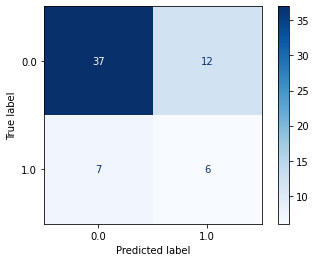

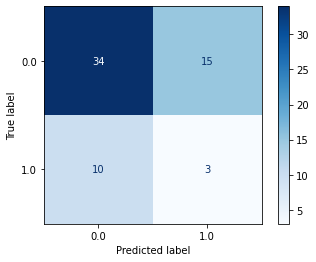

In [109]:
applyModels(genesN)

#####  DNA Methylation

SVM Accuracy: 0.7258064516129032
DecisionTree Accuracy: 0.7096774193548387


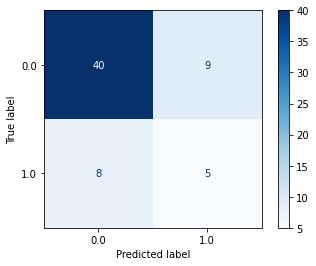

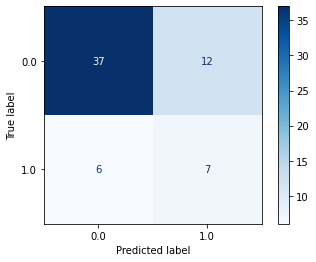

In [110]:
applyModels(methylationN)

##### miRNA

SVM Accuracy: 0.6612903225806451
DecisionTree Accuracy: 0.6129032258064516


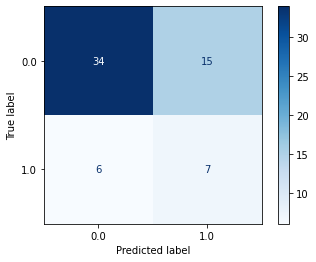

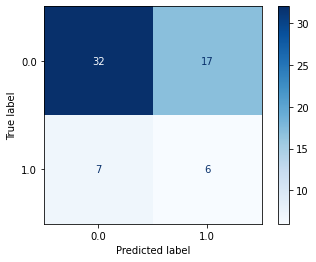

In [111]:
applyModels(mirnaN)

##### Concatenated SET

SVM Accuracy: 0.7419354838709677
DecisionTree Accuracy: 0.5967741935483871


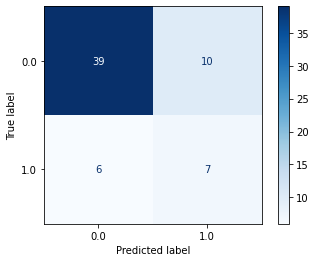

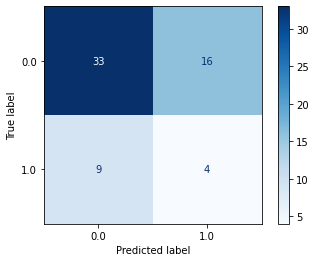

In [112]:
applyModels(concDf)

## Feature Selection in every set

Παίρνει τα normalized sets και κανει feature selection

In [113]:
genesFS = featureSelection(genesN)
mirnaFS = featureSelection(mirnaN)
methylationFS = featureSelection(methylationN)
concDfFS = concatenation(genesFS,methylationFS,mirnaFS)

C:\Users\nikos\Anaconda3\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:115: UserWarning: Features [    5     9    17    23  1392  1581  1749  1765  1844  1888  2320  2342
  2789  3527  4282  4318  4333  4370  4371  4373  4374  4375  4376  4510
  4639  4808  4809  4811  4814  4816  4817  4818  4822  4824  4829  4831
  4835  4836  5288  6051  6191  6697  6699  7230  7262  7510  7661  7662
  7663  7664  7665  7870  8121  8203  9287  9290  9294  9296  9301  9304
  9306  9307  9309  9313  9314  9315  9316  9317  9318  9320  9321  9323
  9325  9334  9335  9350  9351  9352  9355  9357  9452  9453  9470  9523
  9744  9865  9915 10121 10139 10668 11130 11223 11790 11801 11958 12360
 12388 12392 12410 12411 12414 12439 12457 12478 12479 12482 12483 12510
 12511 12515 12516 12518 12521 12522 12539 12553 12554 12556 12559 12619
 12628 12629 12630 12639 12656 12657 12672 12676 12691 12716 12718 12720
 12723 12726 12730 12732 12734 12825 13520 13777 13803 13810 13991 14158
 14

Ξανα γίνεται εφαρμογή των μοντέλων στα νέα sets

###### Genes

SVM Accuracy: 0.7903225806451613
DecisionTree Accuracy: 0.7258064516129032


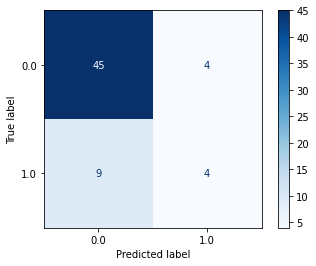

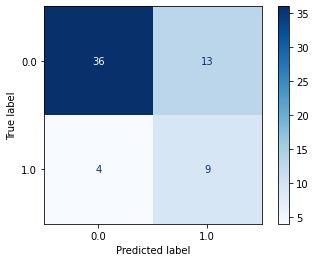

In [114]:
applyModels(genesFS)

##### DNA Methylation

SVM Accuracy: 0.8225806451612904
DecisionTree Accuracy: 0.6129032258064516


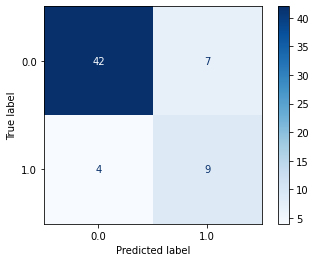

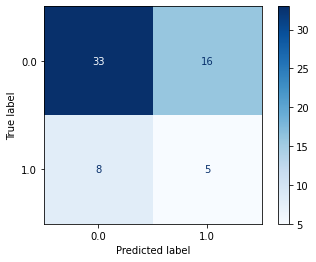

In [115]:
applyModels(methylationFS)

##### miRNA

SVM Accuracy: 0.8548387096774194
DecisionTree Accuracy: 0.6612903225806451


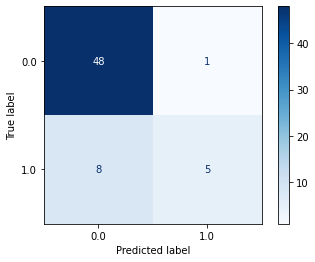

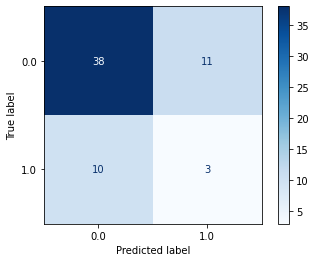

In [116]:
applyModels(mirnaFS)

##### concatenated

SVM Accuracy: 0.8225806451612904
DecisionTree Accuracy: 0.7258064516129032


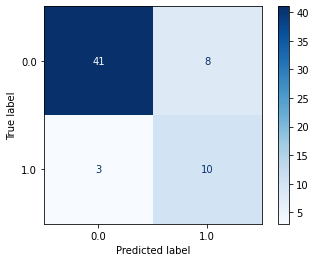

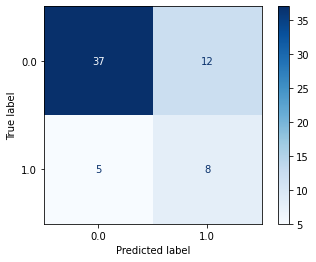

In [117]:
applyModels(concDfFS)

In [72]:
genesFS

,TIGD1|200765,LOC100272217|100272217,LOC100303728|100303728,LOC284900|284900,FLJ45244|400242,ENO3|2027,TAS2R20|259295,TCTE3|6991,LOC100216545|100216545,C9orf37|85026,Death
PatientID,,,,,,,,,,,
TCGA.A6.2675.01,0.074128,0.103261,0.244942,0.232943,0.067630,0.128315,0.183635,0.266856,0.130113,0.147646,0.0
TCGA.A6.4105.01,0.283112,0.167864,0.172389,0.220351,0.080290,0.300206,0.308017,0.244303,0.254295,0.236198,1.0
TCGA.A6.5656.01,0.444310,0.300087,0.590215,0.769824,0.462405,0.289041,0.402086,0.753502,0.744645,0.402004,0.0
TCGA.A6.5657.01,0.060274,0.087970,0.193237,0.572930,0.135129,0.071367,0.162497,0.103759,0.056016,0.235197,0.0
TCGA.A6.5659.01,0.265357,0.140716,0.308579,0.399599,0.131572,0.050823,0.124956,0.240678,0.305808,0.124243,0.0
...,...,...,...,...,...,...,...,...,...,...,...
TCGA.G4.6588.01,0.125012,0.129352,0.110641,0.306104,0.046645,0.169346,0.309092,0.172741,0.092111,0.101044,0.0
TCGA.G4.6625.01,0.190213,0.192075,0.372709,0.382876,0.129718,0.336707,0.444505,0.330011,0.418035,0.503982,0.0
TCGA.G4.6626.01,0.494507,0.165310,0.190183,0.267300,0.214970,0.350860,0.313818,0.410845,0.709758,0.512597,1.0


SMOTE

Counter({0.0: 146, 1.0: 146})
SVM Accuracy: 0.8295454545454546
DecisionTree Accuracy: 0.7613636363636364


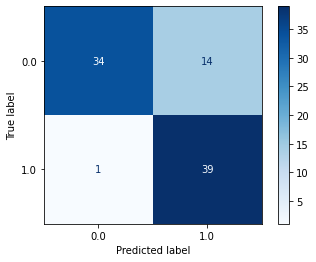

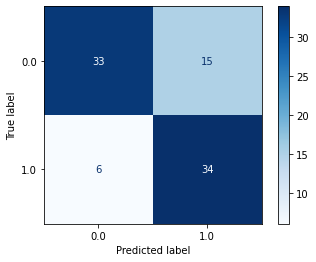

In [118]:
X,y = smoteAlgorithm(concDf)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1) #, random_state=1

#svmAlgorithm(X_train, X_test, y_train, y_test)
#treeAlgorithm(X_train, X_test, y_train, y_test)

y_pred,clf = svmAlgorithm(X_train, X_test, y_train, y_test)
confusionMatrix(X_test,y_test,y_pred,clf)
print("SVM Accuracy:",metrics.accuracy_score(y_test, y_pred))

y_pred,clf = treeAlgorithm(X_train, X_test, y_train, y_test)
print("DecisionTree Accuracy:",metrics.accuracy_score(y_test, y_pred))
confusionMatrix(X_test,y_test,y_pred,clf)